In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive

/tmp/ipykernel_5911/512193917.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/sandoar/miniconda3/envs/model/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def model3(obs, ids1, ids2, num_coaches):
    """
    Inputs:
        obs: obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.
        ids1: A 1D tensor of the same length as obs. Contains the index of the first coach in each game.
        ids2: A 1D tensor of the same length as obs. Contains the index of the second coach in each game.
        num_coaches: The number of coaches in the dataset.

    Output: A 1D tensor of the same length as "obs". Represents a sample from difference in performance between the two coaches.
    """

    hyper_sigma = 1/8
    
    coach_mu_skill = 0
    coach_sigma_skill = 1

    # Sample skills for each coach using a plate for coaches
    with pyro.plate('coaches', num_coaches):
        coach_skills = pyro.sample("coach_skills", dist.Normal(coach_mu_skill, coach_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):
        # Gather the skills for the competing coaches in each match
        coach1_skills = coach_skills[ids1]
        coach2_skills = coach_skills[ids2]

        # Sample performances for the coaches in each match
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skills, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skills, hyper_sigma))

        # Compute the performance difference
        perf_diff = coach1_perf - coach2_perf

        # Sample the observed outcomes
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

In [3]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 12

# fake data to see if this model gets same results as previous model
obs = torch.ones(num_games)
id1 = torch.zeros(len(obs)).long()
id2 = torch.ones(len(obs)).long()
num_coaches = 2
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 431.788373708725
Step 100 : loss = 3.793013095855713
Step 200 : loss = 0.6848008632659912
Step 300 : loss = 2.4982762336730957
Step 400 : loss = 1.844573974609375
Step 500 : loss = 2.1639552116394043
Step 600 : loss = 2.0673484802246094
Step 700 : loss = 1.8288891315460205
Step 800 : loss = -0.5101046562194824
Step 900 : loss = 1.0617084503173828
Step 1000 : loss = -0.4647197723388672
Step 1100 : loss = 2.6221370697021484
Step 1200 : loss = 3.539590835571289
Step 1300 : loss = 5.583215236663818
Step 1400 : loss = 0.8830721378326416
Step 1500 : loss = 3.189321517944336
Step 1600 : loss = 4.516306638717651
Step 1700 : loss = 4.495195508003235
Step 1800 : loss = 6.724966526031494
Step 1900 : loss = 1.636049509048462
Step 2000 : loss = 3.6446213722229004
Step 2100 : loss = 4.769115924835205
Step 2200 : loss = 5.721271276473999
Step 2300 : loss = 3.3238167762756348
Step 2400 : loss = 3.434852123260498
Step 2500 : loss = -1.6010370254516602
Step 2600 : loss = 0.30782556533813

In [4]:
predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, num_coaches)

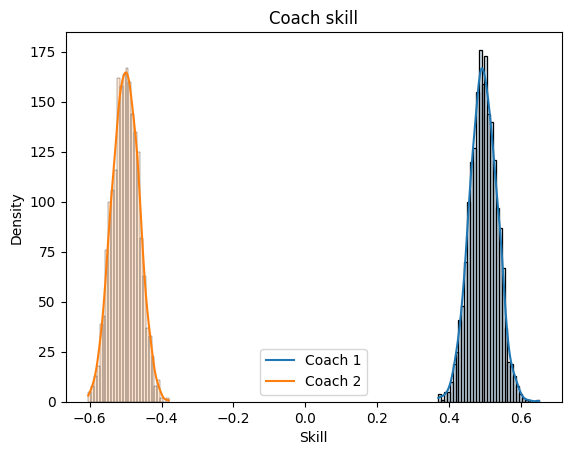

In [5]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")

plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()

# Try and make some fake data with multiple players where the player with the higher index always wins.

In [6]:
num_coaches = 6
# assuming round robin
num_games = 15

# round robin structure generated by chatgpt
id1 = [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]
id2 = [2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]

id1 = torch.tensor(id1).long()
id1 = id1 - 1
id2 = torch.tensor(id2).long()
id2 = id2 - 1

obs = []
for i in range(num_games):
    if id1[i] < id2[i]:
        obs.append(-1)
    else:
        obs.append(1)

obs = torch.tensor(obs)

In [7]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 479.537992477417
Step 100 : loss = 75.91675233840942
Step 200 : loss = 49.78711223602295
Step 300 : loss = 45.721728920936584
Step 400 : loss = 43.49094223976135
Step 500 : loss = 47.070322155952454
Step 600 : loss = 53.87869644165039
Step 700 : loss = 50.854742765426636
Step 800 : loss = 43.07656002044678
Step 900 : loss = 46.94941520690918
Step 1000 : loss = 50.0776172876358
Step 1100 : loss = 45.97532558441162
Step 1200 : loss = 50.21161091327667
Step 1300 : loss = 47.32425355911255
Step 1400 : loss = 48.597193241119385
Step 1500 : loss = 44.33949100971222
Step 1600 : loss = 51.374388456344604
Step 1700 : loss = 44.79090118408203
Step 1800 : loss = 44.13830065727234
Step 1900 : loss = 48.83060026168823
Step 2000 : loss = 47.06732523441315
Step 2100 : loss = 51.127565741539
Step 2200 : loss = 41.98597848415375
Step 2300 : loss = 46.448755621910095
Step 2400 : loss = 46.625877380371094
Step 2500 : loss = 48.720064640045166
Step 2600 : loss = 49.98795008659363
Step 2700

In [8]:
predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, num_coaches)

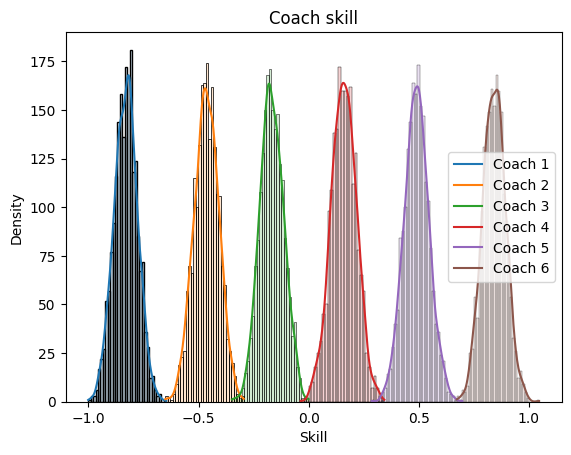

In [9]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


# Try training on real data

In [25]:
# read and format data
df = pd.read_csv('../data/X_train.csv')

# make a list of unique coaches
coaches1 = df['team1_coach_id']
coaches2 = df['team2_coach_id']
unique_coaches = pd.concat([coaches1, coaches2]).unique()
unique_coaches.sort()

num_coaches = len(unique_coaches)

coach_winrates = np.zeros(num_coaches)
coach_num_matches = np.zeros(num_coaches)

for id, coach_id in enumerate(unique_coaches):
    coach1_df = df[df['team1_coach_id'] == coach_id]

    coach_winrates[id] += 0.5 * (coach1_df["team1_win"] == 0).sum()
    coach_winrates[id] += (coach1_df["team1_win"] == 1).sum()

    coach2_df = df[df['team2_coach_id'] == coach_id]
    coach_winrates[id] += 0.5 * (coach1_df["team2_win"] == 0).sum()
    coach_winrates[id] += (coach2_df["team2_win"] == 1).sum()

    coach_winrates[id] = coach_winrates[id] / (len(coach1_df) + len(coach2_df))
    coach_num_matches[id] = len(coach1_df) + len(coach2_df)

indices = np.lexsort((unique_coaches, coach_winrates, coach_num_matches))
# might fuck up when several coaches has the same number of matches.
sorted_coaches = unique_coaches[indices[::-1]]
sorted_winrates = coach_winrates[indices[::-1]]
sorted_num_matches = coach_num_matches[indices[::-1]]

coach_dict = {coach: i for i, coach in enumerate(sorted_coaches)}

# make variables for the model sorted by winrate
id1 = torch.tensor(coaches1.map(coach_dict).values).long()
id2 = torch.tensor(coaches2.map(coach_dict).values).long()

obs = torch.tensor(df['team1_win'].values)
num_games = len(obs)

In [26]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 1940714.7912597656
Step 100 : loss = 511238.86474609375
Step 200 : loss = 471276.4248046875
Step 300 : loss = 461107.0859375
Step 400 : loss = 457607.24365234375
Step 500 : loss = 456368.57666015625
Step 600 : loss = 455525.6994628906
Step 700 : loss = 454667.8564453125
Step 800 : loss = 454965.833984375
Step 900 : loss = 454635.8017578125
Step 1000 : loss = 454654.38916015625
Step 1100 : loss = 454445.421875
Step 1200 : loss = 454530.8474121094
Step 1300 : loss = 454557.40087890625
Step 1400 : loss = 454768.1298828125
Step 1500 : loss = 454200.98828125
Step 1600 : loss = 454122.29248046875
Step 1700 : loss = 454622.4519042969
Step 1800 : loss = 454366.4060058594
Step 1900 : loss = 454387.09521484375
Step 2000 : loss = 454568.5791015625
Step 2100 : loss = 454252.740234375
Step 2200 : loss = 454251.6193847656
Step 2300 : loss = 454209.5732421875
Step 2400 : loss = 454118.5310058594
Step 2500 : loss = 454317.3466796875
Step 2600 : loss = 454350.1350097656
Step 2700 : loss

In [27]:
predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, num_coaches)

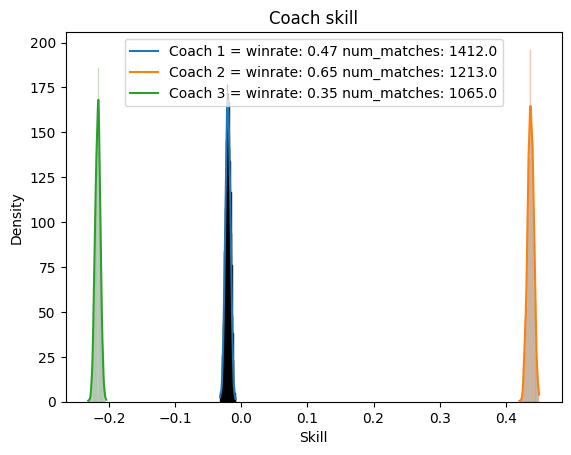

In [28]:
labels = []
for i in range(3):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.2f} num_matches: {sorted_num_matches[i]}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


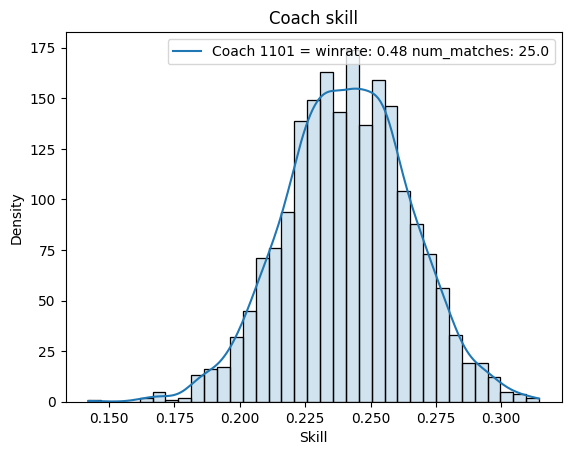

In [35]:
labels = []
for i in range(1100,1101):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.2f} num_matches: {sorted_num_matches[i]}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


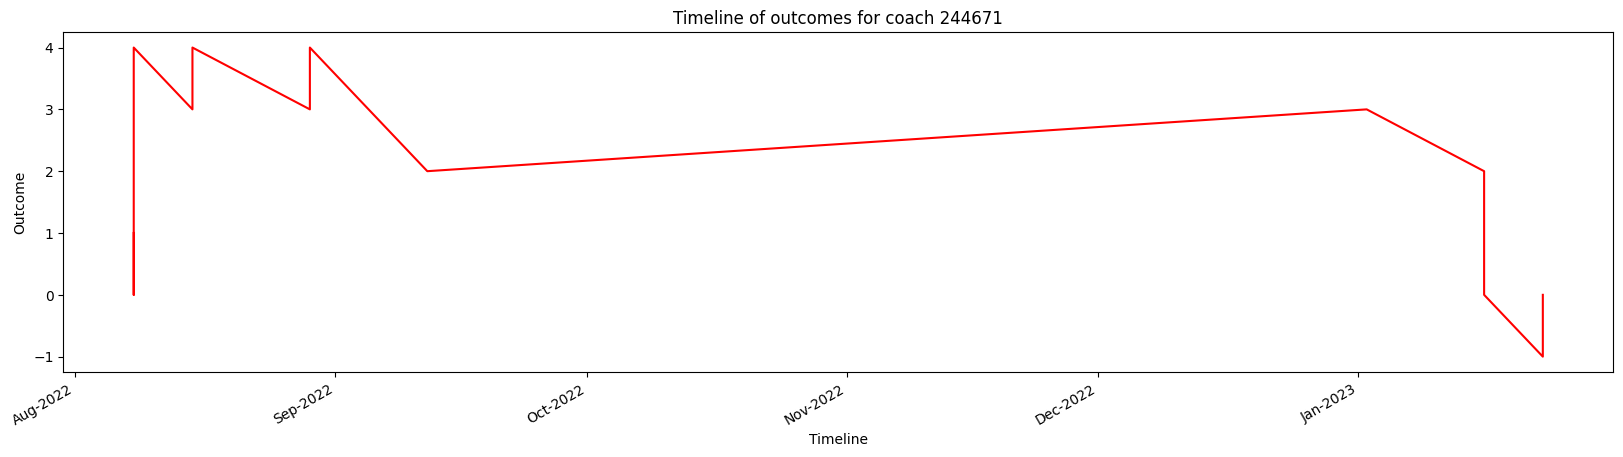

In [36]:
import matplotlib.dates as mdates

df = pd.read_csv('../data/X_train.csv')

# code for plotting the timeline of a coach
coach_index = 1100
coach_id = sorted_coaches[coach_index]

mask = df['team2_coach_id'] == coach_id
df.loc[mask, 'team2_win'] *= -1
df.loc[mask, 'team1_win'] *= -1

coach1_df = df[df['team1_coach_id'] == coach_id].copy()
coach2_df = df[df['team2_coach_id'] == coach_id].copy()

coach_df = pd.concat([coach1_df, coach2_df])
coach_df['week_date'] = pd.to_datetime(coach_df['week_date'])
coach_df = coach_df.sort_values(by='week_date')

# plot the timeline of outcomes for the given coach
plt.figure(figsize=(20, 5))
plt.plot(coach_df['week_date'], np.cumsum(coach_df['team1_win']), 'r')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # 'Month-Year' format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # set locator to month
plt.gcf().autofmt_xdate()  # autoformat the x-axis date
plt.xlabel("Timeline")
plt.ylabel("Outcome")
plt.title(f"Timeline of outcomes for coach {coach_id}")
plt.show()
